In [258]:
import pandas as pd
import numpy as np
import re
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.cross_validation import train_test_split, KFold
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

# Load Data

In [2]:
df = pd.read_csv("clean_data2.csv",delimiter=",",low_memory=False)
print df.shape
df.head(10)

(11326, 1450)


CMI:75 F3a) Epilepsy: Ever suffered  \
0                                  3.0   
1                                  3.0   
2                                  3.0   
3                                  3.0   
4                                  3.0   
5                                  3.0   
6                                  3.0   
7                                  3.0   
8                                  3.0   
9                                  3.0   

   1P Child 8 years-old at NCDS1 Parental  \
0                                     NaN   
1                                     NaN   
2                                     NaN   
3                                     NaN   
4                                     NaN   
5                                     1.0   
6                                     NaN   
7                                     NaN   
8                                     NaN   
9                                     NaN   

   1P Family moves since child's birth  1P Moves out of local area  \
0                                  1.0                         3.0   
1                                  3.0                         2.0   
2                                  3.0                         3.0   
3                                  NaN                         NaN   
4                                 12.0                         2.0   
5                                  0.0                         1.0   
6                                  0.0                         1.0   
7                                  0.0                         1.0   
8                                  2.0                         2.0   
9                                  1.0                         3.0   

   1P Informant's relationship to child  \
0                                   1.0   
1                                   1.0   
2                                   1.0   
3                                   NaN   
4                                   2.0   
5                                   1.0   
6                                   1.0   
7                                   1.0   
8                                   1.0   
9                                   1.0   

   1P No. kids undr 21 hhld,inc liv away  \
0                                    3.0   
1                                    2.0   
2                                    2.0   
3                                    NaN   
4                                    2.0   
5                                    8.0   
6                                    4.0   
7                                    6.0   
8                                    2.0   
9                                    4.0   

   1P Number of people in the household  1P Child's posn hhld ,inc those away  \
0                                   5.0                                   1.0   
1                                   4.0                                   2.0   
2                                   4.0                                   2.0   
3                                   NaN                                   NaN   
4                                   4.0                                   1.0   
5                                   NaN                                   6.0   
6                                   6.0                                   3.0   
7                                   8.0                                   4.0   
8                                   4.0                                   1.0   
9                                   6.0                                   1.0   

   1P Relationship person acting as mother  \
0                                      2.0   
1                                      2.0   
2                                      2.0   
3                                      NaN   
4                                      2.0   
5                                      2.0   
6                                      2.0   
7                                      2.0   
8       

In [28]:
#I have already deleted these relevant predictors
drop = ["1M Epileptic condition","1M Reason for Special Education MC3:3","1M Reason for Special Education MC2:3","1M Reason for Special Education MC1:3","2P Has child had epilepsy attacks-MC 3:3","2P Has child had epilepsy attacks-MC 2:3",
        "2P Has child had epilepsy attacks-MC 1:3","2M Reason for special education - MC1:3","2M Reason for special education - MC2:3",
        "2M Reason for special education - MC3:3","2P Age at most recent epilepsy attack","2P Age at 1st epilepsy attack"
       ,"3P Nature of child-s disability-MC 1:5","3P Nature of child-s disability-MC 2:5","3P Nature of child-s disability-MC 4:5",
        "3P Nature of child-s disability-MC 5:5","3M Category of child's handicap MC1:3","3M Category of child's handicap MC2:3",
       "3M Category of child's handicap MC3:3","3M Reason for hosp admiss last 12 mnths","3M Reason hosp outpatient last yr"
       ,"3M Epilepsy","3M CNS condition,other than epilepsy","CMI:75 F3b) Epilepsy: Suffered in last12 months","CMI:75 F3c) Epilepsy: Seen doctor in last 12 months" ]

# **Instructions**:
The dataset is a combination (merge by ID number) of sweep 0-3 and sweep 5. There are in total 11326 samples with 1474 predictors and one response at the **first** row. I manually filtered good variables related to predicting epilepsy:

### sweep0-3:
- 1P NCDS1 (1965) Parental Questionnaire 
- 1PD NCDS1 (1965) Parental Questionnaire (Derived Variable) 
- 1M NCDS1 (1965) Medical Questionnaire 
- ~~1S NCDS1 (1965) Educational Assessment~~ 
- 1D NCDS1 (1965) Derived Variable 
- 2P NCDS2 (1969) Parental Questionnaire 
- 2M NCDS2 (1969) Medical Questionnaire 
- 3P NCDS3 (1974) Parental Interview 
- ~~3S NCDS3 (1974) Educational Questionnaire~~ 
- 3M NCDS3 (1974) Medical Examination 

### sweep6:
Health variables from NCDS official website.  
http://www.cls.ioe.ac.uk/datadictionary/page.asp?section=000100010001001000010007&sectionTitle=G+%2D+Health

**Response variable: N503930	CMI:75 F3a) Epilepsy: Ever suffered**:

    Pos. = 1140	Variable = n503930	Variable label = CMI:75 F3a) Epilepsy: Ever suffered  
    This variable is  numeric, the SPSS measurement level is ORDINAL 

    Value label information for n503930  
    Value = 1.0	Label = Yes  
    Value = 2.0	Label = Only when pregnant  
    Value = 3.0	Label = No  

#  Random Forest Classification

In [6]:
target = "CMI:75 F3a) Epilepsy: Ever suffered"
print "with epilepsy: ", len(df[target][df[target] == 1])
print "with epilepsy only when pregnant: ",len(df[target][df[target] == 2])
print "without epilepsy: ", len(df[target][df[target] == 3])

with epilepsy:  141
with epilepsy only when pregnant:  22
without epilepsy:  11163


**Ideas**: For the whole population part, maybe delete samples **with epilepsy only when pregnant** and do a binary classification. We can further target at women to do three class classification. :)

In [9]:
# Turn to a binary classifier
df[target][df[target] == 2] = 0
df[target][df[target] == 3] = 0

In [18]:
# Drop columns with excessive missing data
for column in df.columns:
    null_ratio = sum(df[column].isnull()) / float(len(df[column]))
    if null_ratio > 0.25:
        del df[column]

In [48]:
# Fill in missing data
for column in df.columns:
    # If the column is categorical, fill in with most common
    if len(df[column].unique()) <= 8:
        df[column].fillna(df[column].mode()[0], inplace=True)
    else:
        df[column].fillna(df[column].mean(), inplace=True)

In [50]:
# One-hot encode
new_df = pd.DataFrame()

for column in df.columns:
    # If the column is categorical
    if len(df[column].unique()) <= 8 and len(df[column].unique()) > 2:
        dummies = pd.get_dummies(df[column], prefix="{}: ".format(column))
        new_df = pd.concat((new_df, dummies), axis = 1)
    else:
        new_df[column] = df[column]

In [51]:
print new_df.shape

(11326, 2479)


In [57]:
y = new_df[target]
x = new_df.drop(target, axis=1)

In [254]:
x_train, x_test, y_train, y_test = train_test_split(x, y, train_size = 0.75)

In [289]:
weights = [80 + 5 * i for i in range(0, 7)]
healthy_scores = []
epilepsy_scores = []
scores = []
k = 5
kfold = KFold(len(x), n_folds=k)

for weight in weights:
    healthy_score = 0
    epilepsy_score = 0
    score = 0
    for tr, te in kfold:
        rf = RandomForestClassifier(max_depth = 3, class_weight={
                1: weight
            })
        rf.fit(x.iloc[tr,:], y.iloc[tr])
        preds = rf.predict(x.iloc[te, :])
        y_test = np.array(y.iloc[te])
        
        
        score += rf.score(x.iloc[te, :], y.iloc[te])
        healthy_score += sum(preds[y_test == 0] == y_test[y_test == 0]) / float(len(y_test[y_test == 0]))
        epilepsy_score += sum(preds[y_test == 1] == y_test[y_test == 1]) / float(len(y_test[y_test == 1]))
    
    scores.append(score / k)
    healthy_scores.append(healthy_score / k)
    epilepsy_scores.append(epilepsy_score / k)

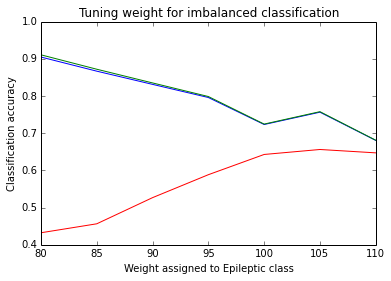

In [290]:
plt.plot(weights, scores, label="All patients")
plt.plot(weights, healthy_scores, label="Healthy patients")
plt.plot(weights, epilepsy_scores, label="Epileptic patients")
plt.xlabel("Weight assigned to Epileptic class")
plt.ylabel("Classification accuracy")
plt.title("Tuning weight for imbalanced classification")

In [295]:
best_weight = 105

In [296]:
n_estimators = [10 + i*10 for i in range(1, 10)]
healthy_scores = []
epilepsy_scores = []
scores = []
k = 5
kfold = KFold(len(x), n_folds=k)

for n in n_estimators:
    healthy_score = 0
    epilepsy_score = 0
    score = 0
    for tr, te in kfold:
        rf = RandomForestClassifier(n_estimators = n, max_depth = 3, class_weight={
                1: 105
            })
        rf.fit(x.iloc[tr,:], y.iloc[tr])
        preds = rf.predict(x.iloc[te, :])
        y_test = np.array(y.iloc[te])
        
        
        score += rf.score(x.iloc[te, :], y.iloc[te])
        healthy_score += sum(preds[y_test == 0] == y_test[y_test == 0]) / float(len(y_test[y_test == 0]))
        epilepsy_score += sum(preds[y_test == 1] == y_test[y_test == 1]) / float(len(y_test[y_test == 1]))
    
    scores.append(score / k)
    healthy_scores.append(healthy_score / k)
    epilepsy_scores.append(epilepsy_score / k)

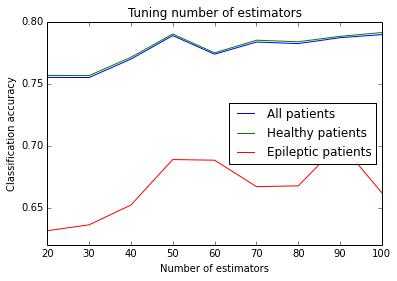

In [300]:
plt.plot(n_estimators, scores, label="All patients")
plt.plot(n_estimators, healthy_scores, label="Healthy patients")
plt.plot(n_estimators, epilepsy_scores, label="Epileptic patients")
plt.xlabel("Number of estimators")
plt.ylabel("Classification accuracy")
plt.legend(loc="best")
plt.title("Tuning number of estimators")
plt.show()

In [301]:
best_n = 50

In [311]:
rf = RandomForestClassifier(n_estimators = best_n, max_depth = 3, class_weight={
                1: best_weight
            })
rf.fit(x, y)

RandomForestClassifier(bootstrap=True, class_weight={1: 105},
            criterion='gini', max_depth=3, max_features='auto',
            max_leaf_nodes=None, min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=50, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [312]:
importances = [(new_df.columns[i], imp) for i, imp in enumerate(rf.feature_importances_)]
importances_sorted = sorted(importances, key = lambda i: i[1], reverse=True)

In [313]:
for imp in importances_sorted[:20]:
    print imp[0]

CMI:75 F3a) Persistent mouth/gum trouble: Ever suffered: _3.0
CMI:82 F33a) Regular medical supervision for other conditions
CMI:94 F74a) ROAD TRAFFIC ACCIDENT 4: Incident No. (F36a): _8.0
CMI:91 F63a) Ever get out of breath ineveryday activities
CMI:85 F39c 10th most recent hospital admission - Reason 3
2M Eye used to look down tube-MC 2:2
CMI:91 F65) CHECK: F65b) - CM has fullcar/van licence
2P Ever seen spec-asthma,whzy bronchitis: _5.0
CMI:92 F71 No. times driven/ridden over limit in last 12 months: _4.0
CMI:88 F54a) Ever had drink to steady hands, etc first thing in day
CMI:78 F21 Suffered any 'emotional problem' since March 1981
CMI:86 F40 MALAISE  4: Often have bad head-aches
2P Ever seen specialist-convulsions,fits: _4.0
CMI:92 F72 CM/other household member owns: Vehicle #1: _5.0
2M No. squares marked-left hand in 1min
CMI:88 F50b) No. measures spirits/liqueurs in lst 7 days
2M MO-access to school medical record
2P Ever seen specialist-convulsions,fits: _1.0
CMI:88 F56a) Ever ha

In [314]:
depths = [2, 3,4, 5]
healthy_scores = []
epilepsy_scores = []
scores = []
k = 5
kfold = KFold(len(x), n_folds=k)

for d in depths:
    healthy_score = 0
    epilepsy_score = 0
    score = 0
    for tr, te in kfold:
        rf = RandomForestClassifier(n_estimators = best_n, max_depth = d, class_weight={
                1: best_weight
            })
        rf.fit(x.iloc[tr,:], y.iloc[tr])
        preds = rf.predict(x.iloc[te, :])
        y_test = np.array(y.iloc[te])
        
        
        score += rf.score(x.iloc[te, :], y.iloc[te])
        healthy_score += sum(preds[y_test == 0] == y_test[y_test == 0]) / float(len(y_test[y_test == 0]))
        epilepsy_score += sum(preds[y_test == 1] == y_test[y_test == 1]) / float(len(y_test[y_test == 1]))
    
    scores.append(score / k)
    healthy_scores.append(healthy_score / k)
    epilepsy_scores.append(epilepsy_score / k)

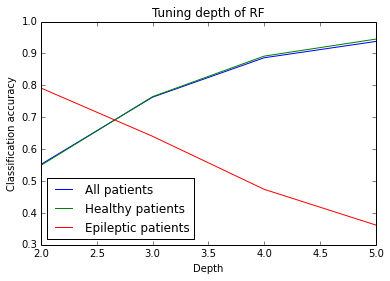

In [316]:
plt.plot(depths, scores, label="All patients")
plt.plot(depths, healthy_scores, label="Healthy patients")
plt.plot(depths, epilepsy_scores, label="Epileptic patients")
plt.xlabel("Depth")
plt.ylabel("Classification accuracy")
plt.legend(loc="best")
plt.title("Tuning depth of RF")
plt.show()